# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
c = 299792.458  # km/s

def GetDopplerShift(f_c, f_m):
    DS = (f_m - f_c)/f_c
    return DS
    
def get_v_radial(f_c, f_m):
    v_r = c * GetDopplerShift(f_c, f_m)
    return v_r

In [3]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [4]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [5]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [6]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


# Get Doppler Shift data from F_c and F_m

In [7]:
f_c = obj['data'][0]['channel_f_center']

In [8]:
tau = []
DS = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_DS   = []
    
    for s in stream:
        aux_tau.append( float(s['time_system']))
        aux_DS.append( GetDopplerShift(f_c, float(s['f']) ))

    print("Stream length: {}".format(len(aux_DS)))
    tau.append(aux_tau)
    DS.append(aux_DS)

        

Sat ID: 1
Stream length: 396
Sat ID: 1
Stream length: 401
Sat ID: 1
Stream length: 389
Sat ID: 1
Stream length: 392


In [120]:
M = 0

for i in range(N):
    print(len(tau[i]))
    M += len(tau[i])
    
print('Total number of Measurements M = {}'.format(M))

396
401
389
392
Total number of Measurements M = 1578


### Doppler Shift measured by Ground Stations

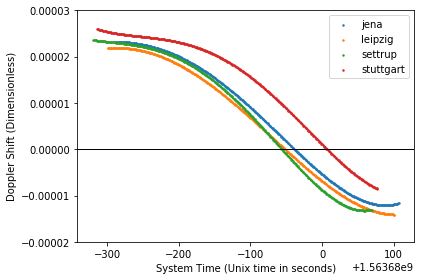

In [10]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], DS[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

### Calculating GS positions and velocities in the GeoCentric Reference System

In [11]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [12]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [13]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
In this case around 8 minutes per four stations (~1600 observations)

In [14]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-19 18:33:50.964830
iteration 0 ends at time 2019-08-19 18:35:58.622878
iteration 1 starts at time 2019-08-19 18:35:58.623683
iteration 1 ends at time 2019-08-19 18:37:46.554634
iteration 2 starts at time 2019-08-19 18:37:46.555108
iteration 2 ends at time 2019-08-19 18:39:48.836496
iteration 3 starts at time 2019-08-19 18:39:48.836991
iteration 3 ends at time 2019-08-19 18:41:50.727775


### How it looks:

In [15]:
GS_gcrs_positions[0][:3]

[<CartesianRepresentation (x, y, z) in m
     (4035733.15241229, 145414.66606224, 4920400.42424484)>,
 <CartesianRepresentation (x, y, z) in m
     (4035722.53151958, 145708.28469782, 4920400.44934099)>,
 <CartesianRepresentation (x, y, z) in m
     (4035711.88928253, 146001.9025695, 4920400.47448436)>]

In [16]:
GS_gcrs_velocities[0][:3]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61021292, 293.61897176, 0.02508017)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.63158776, 293.61823837, 0.02513502)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.65306942, 293.61744395, 0.02515935)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [17]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

396 396 396
401 401 401
389 389 389
392 392 392


### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [18]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(N):
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [19]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.15241229, 145414.66606224, 4920400.42424484)>

In [20]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(GS_av)

(4035908.8206081325, 140422.9764828612, 4920400.006621368)


### Generate the initial positions of Random Walkers

In [21]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

This is the average position of the Ground Stations at the first measurement.

In [22]:
GS_av_unitary = GS_av / norm(GS_av)

This is a point 500 kilometers above the GS_average point.

In [23]:
H_0 = 500 * u.km

Earth.R + H_0

<Quantity 6878136.6 m>

In [24]:
R0 = (Earth.R + H_0) * GS_av_unitary
print(R0)

[4360987.55773497  151733.56992976 5316721.5023261 ] m


And a random initial velocity, just to test the Orbit Generation from vectors

In [25]:
GM_E = poliastro.constants.GM_earth

V0 = (GM_E / (Earth.R + H_0))**0.5

In [26]:
V0

<Quantity 7612.60839458 m / s>

In [27]:
V0.value

7612.6083945805685

# Orbit generated from vectors

In [28]:
nwalkers = 20
ndim = 6
MCMC_steps = 50

In [156]:
## To generate circular orbits with initial positions above the first measurement.

z_unitary = np.array([0, 0, 1])
vec_in_plane = np.cross(z_unitary, GS_av_unitary)
v_1 = vec_in_plane / norm( list(vec_in_plane) )
v_2 = np.cross( GS_av_unitary, v_1 )


DeltaR0 = 100
DeltaV0 = 5

def init_R0s(R0, nwalkers):
    R0x = R0[0]
    R0y = R0[1]
    R0z = R0[2]
      
    retx = np.random.normal(R0x, DeltaR0, nwalkers)
    rety = np.random.normal(R0y, DeltaR0, nwalkers)
    retz = np.random.normal(R0z, DeltaR0, nwalkers)
    
    ret = np.array([retx, rety, retz])
    return ret.T

def init_V0s(V1, V2, nwalkers):
    
    theta = np.random.random(nwalkers)
    
    A1 = V1 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.cos( 2 * np.pi * theta) ).T
    A2 = V2 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.sin( 2 * np.pi * theta) ).T
    
    ret =  A1 + A2
    
    return ret
    

# Likelihood

In [157]:
c = 299792.458 * u.km / u.s

def redshift(f_0, Vradial ):
    
    return f_0 * (1 + Vradial / c)

In [158]:
R = init_R0s( (R0[0].value, R0[1].value, R0[2].value) , nwalkers)
V = init_V0s( v_1, v_2 ,nwalkers)
P0 = np.hstack((R,V))
P0[:,3:]

array([[ 3951.62484597, -5732.74708619, -3077.67420168],
       [-1996.0643338 ,  7205.41510181,  1431.61690237],
       [ -753.58284906, -7529.27861709,   832.99637758],
       [ 5763.38170487, -1685.14946201, -4679.26374379],
       [-1515.99727098,  7388.3178482 ,  1032.62685304],
       [ 3951.9363739 ,  5547.52025024, -3399.85654683],
       [-5411.30438992,  3122.80395806,  4349.4467244 ],
       [ 4072.29617553, -5590.28030443, -3180.71950129],
       [ 2684.94031932,  6709.15634188, -2393.76758087],
       [-5773.94451762, -1348.17057951,  4774.49550897],
       [-5416.37847282, -2854.18894542,  4524.18570267],
       [-1458.91968936, -7338.00315776,  1406.08305796],
       [ 2327.80269661, -7043.77260005, -1708.3350765 ],
       [-4536.97964409,  4954.91604947,  3580.00408115],
       [ 5877.41073773,  -568.35130476, -4804.66714597],
       [ 3435.46699903,  6098.97650273, -2991.96568947],
       [ 5406.04317016, -3138.50803929, -4344.68308383],
       [ 2911.94502097,  6545.2

In [159]:
TestOrbit = Orbit.from_vectors(Earth, P0[0][:3] * u.m, P0[0][3:] * u.m/u.s, epoch=tau_astropytime[0][0] )

In [160]:
def lnprob( param ):
    x, y, z, vx, vy, vz = param
    
    r = (x**2 + y**2 + z**2)**0.5
    
    # Reject orbits "inside" the Earth
    if Earth.R.value > r:        
        print(r)
        return -np.inf
    
    tau_0 = tau_astropytime[0][0]
    r_init = np.array([x,y,z]) * u.m
    v_init = np.array([vx, vy, vz]) * u.m / u.s
    myOrbit = Orbit.from_vectors(Earth, r_init, v_init, epoch=tau_0)
    
    
    # Reject hyperbolic orbits
    if(myOrbit.a.value <0):
        raise Exception("Negative major semi-axe. CHECK INITIAL SPEED and its UNITS")
        return -np.inf
    
    # If the perigee is less than Earth Radius.
    if( TestOrbit.a * (1-TestOrbit.ecc) < Earth.R):
        print("Orbit fails. crash")
        return -np.inf
    else:
        print("Good orbit!")
        print("Orbit Eccentricity: {}".format(myOrbit.ecc))
    

    chi2 = 0
    for i in range(N):
        for j in range(len(tau_astropytime[i])):
            chi_aux = 0
            
            t_prime = tau_astropytime[i][j]
            DeltaT = t_prime - tau_0
            
            orbit_at_t_prime = myOrbit.propagate(DeltaT)
                        
            r_sat = orbit_at_t_prime.state.r
            v_sat = orbit_at_t_prime.state.v
            
            r_gs  = GS_gcrs_positions[i][j].get_xyz()
            v_gs  = GS_gcrs_velocities[i][j].get_xyz()

            
            r      = r_sat - r_gs
            r_unit =  r / norm(r)
            v      = v_sat - v_gs
            
            ds_mcmc = v.dot(-r_unit)/c
            ds_obs  = DS[i][j]
            
            chi_aux = ((ds_mcmc - ds_obs) / ds_obs)**2 / (M - 6)
            
            #print( 'Chi2 {:03.8f} measured {:03.8f} mcmcm {:03.8f} '.format(chi_aux, ds_obs, ds_mcmc) )
            
            
            chi2 += chi_aux

    print("Chi2 = {}".format(chi2))
    return chi2

In [161]:
for i in range(1):
    lnprob(P0[i])

Good orbit!
Orbit Eccentricity: 1.5149958698974955e-05
Chi2 = 1930.9896069719234


In [167]:
emcee.__version__

'2.2.1'

In [168]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [ ]:
pos, prob, state = sampler.run_mcmc(P0, MCMC_steps)


Good orbit!
Orbit Eccentricity: 1.5149958698974955e-05
Chi2 = 1930.9896069719234
Good orbit!
Orbit Eccentricity: 1.575872872686529e-05
Chi2 = 1654.1997212732606
Good orbit!
Orbit Eccentricity: 2.9934900230274753e-05
Chi2 = 1963.3289768743903
Good orbit!
Orbit Eccentricity: 1.2567542916327763e-05
Chi2 = 1848.5528275994118
Good orbit!
Orbit Eccentricity: 1.551205923624495e-05
Chi2 = 1650.7807820747164
Good orbit!
Orbit Eccentricity: 2.660653075942429e-05
Chi2 = 1695.404838378164
Good orbit!
Orbit Eccentricity: 1.5296299116393466e-05
Chi2 = 1735.511823232997
Good orbit!
Orbit Eccentricity: 2.667798333795675e-05
Chi2 = 1928.2675868115757
Good orbit!
Orbit Eccentricity: 1.323084613413849e-05
